In [1]:
import numpy as np
import numpy.ma as ma
import cv2
import matplotlib.pyplot as plt
import scipy

import tomopy

from PIL import Image
from glob import glob
from tqdm import tqdm
from cv2 import resize, remap
from scipy.ndimage import median_filter
import scipy.misc

import sys
sys.path.append('..')
sys.path.append('../scripts')
sys.path.append('./scripts')

import reconstruction
from loguru import logger

from theta_correction import theta_correction, center_correction
from multiprocessing import Pool
from skimage.transform import radon, iradon

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
proj_dir = '/mnt/nas/Lab/20190313_No6_hippo_2/rod3/part3_3/proj/'
ring_removal = 0
angle_shift = False

z = 1000

In [4]:
# get projection filenames
logger.info("Finding projection filenames")
proj_files = sorted(glob(proj_dir + '/tomo*.tif'))

# read background
logger.info("Reading background")
df_projection, ff_projection = reconstruction.read_background(proj_dir)

# read and align projections
logger.info("Finding alignment matrix and angles")
align_matrix, angles = reconstruction.find_align_matrix(proj_files, df_projection, ff_projection)

logger.info("Reading and aligning projections")
projections, angles = reconstruction.read_aligned(proj_files, df_projection, ff_projection)

if ring_removal != 0:
    logger.info("Performing ring removal")
    projections = reconstruction.ring_removal(projections, ring_removal == 2)

if angle_shift:
    logger.info("Finding correct angles")

original_angles = angles.copy()

2023-10-25 18:11:05.128 | INFO     | __main__:<module>:2 - Finding projection filenames
2023-10-25 18:11:05.335 | INFO     | __main__:<module>:6 - Reading background
2023-10-25 18:11:07.189 | INFO     | __main__:<module>:10 - Finding alignment matrix and angles
2023-10-25 18:11:31.455 | INFO     | __main__:<module>:13 - Reading and aligning projections
Reading projections: 100%|██████████████████████████████████████████████████████████████████████████| 601/601 [01:21<00:00,  7.36it/s]


In [5]:
angles = original_angles.copy()

In [3]:
# np.save('sample_sinogram.npy', sample_sinogram)
# np.save('angles.npy', angles)

sample_sinogram = np.load('./sample_sinogram.npy')
original_angles = np.load('./angles.npy')

In [4]:
np.linspace(0, 2160, 5+2)[1:-1].astype(int)

array([ 360,  720, 1080, 1440, 1800])

In [9]:
sample_sinogram.shape

(601, 5, 2560)

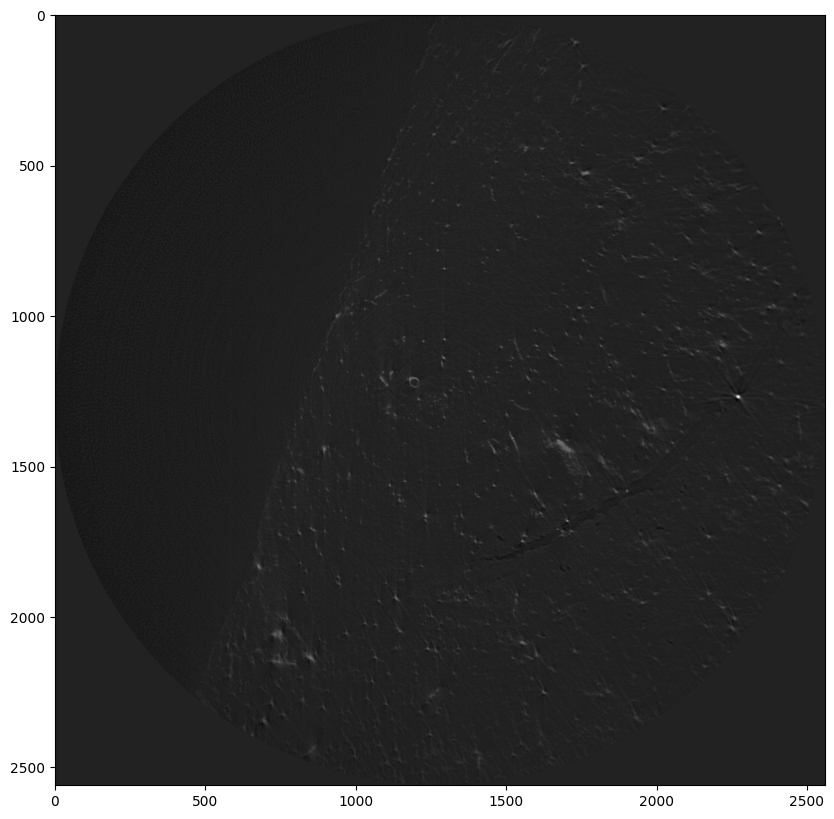

In [16]:
recon_centered = reconstruction.reconstruct(sample_sinogram[:, 1:2, :], angles)

plt.figure(figsize=(10, 10))
plt.imshow(recon_centered[0], cmap='binary')

In [5]:
sample_indices = np.linspace(0, projections.shape[1], 5+2)[1:-1].astype(int)
sample_sinogram = projections[:, sample_indices, :]

centers, angles = center_correction(sample_sinogram.transpose(1, 0, 2), sample_indices, projections.shape[1], angles, (-10, 10), (-2, 2), 30, 300)

|   iter    |  target   | end_ce... | start_... | theta_... |
-------------------------------------------------------------
| 44        | -0.000313 | -0.1714   | -0.05115  | -0.005245 |
| 95        | -0.000313 | -3.536    | 8.963     | -0.001581 |
| 205       | -0.000313 | 6.705     | 9.328     | -0.03888  |
| 261       | -0.000312 | 5.842     | 3.643     | -0.03588  |
| 263       | -0.000312 | 5.891     | 4.038     | -0.006264 |
| 325       | -0.000312 | 8.525     | 7.161     | -0.02988  |


In [8]:
center_corrected_agles = angles.copy()

In [9]:
angles = theta_correction(sample_sinogram.transpose(1, 0, 2), angles, centers[sample_indices], 8, (-0.015, 0.015), 30, 300)

|   iter    |  target   |  input0   |  input1   |  input2   |  input3   |  input4   |  input5   |  input6   |  input7   |
-------------------------------------------------------------------------------------------------------------------------
| 109       | -0.000311 | -0.005014 | -0.002382 | -0.000957 | 0.0004268 | 0.003084  | 0.002794  | 0.002289  | 0.003503  |
| 148       | -0.000311 | -0.003338 | 0.001644  | 0.002377  | 0.005847  | 0.007818  | 0.008732  | 0.00963   | 0.00829   |
| 202       | -0.000311 | -0.002534 | 0.0006834 | 0.002163  | 0.004347  | 0.005359  | 0.006443  | 0.00767   | 0.005525  |
| 212       | -0.000311 | -0.008457 | -0.003222 | -0.001565 | -0.000903 | 0.0004349 | 0.00173   | 0.002951  | 0.00315   |
| 218       | -0.000311 | -0.002552 | 0.002696  | 0.002966  | 0.004519  | 0.006695  | 0.007205  | 0.006777  | 0.006543  |
| 226       | -0.000311 | -0.005234 | 0.001969  | 0.002371  | 0.003577  | 0.004727  | 0.005574  | 0.005634  | 0.004953  |
| 266       | -0.000311 